In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [2]:
ANALYSIS_BASE = "/Volumes/Analysis"

In [3]:
dataset = "2020-10-18-5"
estim = "data006/data006-all_v2/"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [4]:
wnoise = "kilosort_data002/data002"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [9]:
patterns = np.array([2])
n = 197

In [10]:
all_elecs = []
neg_inds_total = 0
pos_inds_total = 0

for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = os.path.join("/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_periphery-affinity_cosine", dataset, estim, wnoise, "p" + str(p))

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]
    good_inds = np.where(triplet_probs > 0.08)[0]
    all_elecs.append(triplet_elecs)

    pos_inds_total += len(pos_inds)
    neg_inds_total += len(neg_inds)

Pattern 2


In [11]:
len(good_inds)

1234

/tmp/ipykernel_7508/4160244106.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


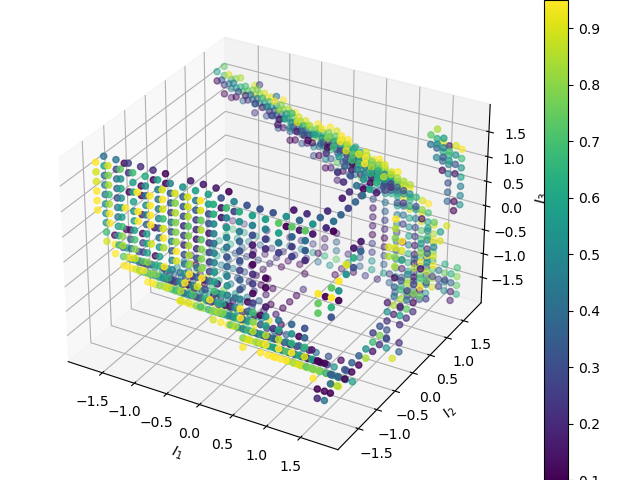

In [12]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

sc = ax.scatter(amplitudes[:, 0][good_inds], 
            amplitudes[:, 1][good_inds],
            amplitudes[:, 2][good_inds], c=triplet_probs[good_inds])

clb = plt.colorbar(sc)
plt.show()

In [ ]:
plt.scatter(1, 1)

In [ ]:
pos_inds_total, neg_inds_total

In [ ]:
all_elecs_array = np.unique(np.array(all_elecs))

In [ ]:
all_elecs_array

In [ ]:
X_pos = []
y_pos = []

X_neg = []
y_neg = []

trials_pos = []
trials_neg = []

In [ ]:
for i in range(len(patterns)):
    p = patterns[i]
    print("Pattern " + str(p))
    filepath = (
        "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity/"
        + dataset
        + "p"
        + str(p)
        + "/"
    )

    triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    triplet_trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(
            filepath
            + "gsort_tri_v2_n"
            + str(n)
            + "_p"
            + str(p)
            + "_k"
            + str(k)
            + ".pkl",
            "rb",
        ) as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["prob"]
            triplet_trials[k] = prob_dict["num_trials"]

    neg_inds = np.where((np.all(amplitudes < 0, axis=1)) & (triplet_probs > 0.08))[0]
    pos_inds = np.where((np.all(amplitudes > 0, axis=1)) & (triplet_probs > 0.08))[0]

    elec_inds = np.searchsorted(all_elecs_array, triplet_elecs)

    y = triplet_probs[pos_inds]
    X = amplitudes[pos_inds]
    trials = triplet_trials[pos_inds]
    X_pos_p = np.zeros((len(pos_inds), len(all_elecs_array)))
    X_pos_p[:, elec_inds] = X
    X_pos.append(X_pos_p)
    y_pos.append(y)
    trials_pos.append(trials)

    y = triplet_probs[neg_inds]
    X = amplitudes[neg_inds]
    trials = triplet_trials[neg_inds]
    X_neg_p = np.zeros((len(neg_inds), len(all_elecs_array)))
    X_neg_p[:, elec_inds] = X
    X_neg.append(X_neg_p)
    y_neg.append(y)
    trials_neg.append(trials)

    print(all_elecs_array)
    print(triplet_elecs)
    print(elec_inds)
    print(amplitudes[neg_inds])
    print(X_neg_p)
    print(y)
    print(trials)

In [ ]:
all_amps_neg = np.vstack(X_neg)
all_probs_neg = np.hstack(y_neg)
trials_neg = np.hstack(trials_neg)

In [ ]:
all_amps_pos = np.vstack(X_pos)
all_probs_pos = np.hstack(y_pos)
trials_pos = np.hstack(trials_pos)

In [ ]:
all_amps_neg

In [ ]:
all_amps_pos.shape, all_probs_pos.shape, trials_pos.shape

In [ ]:
train_amps_pos, test_amps_pos, train_probs_pos, test_probs_pos, train_trials_pos, _ = train_test_split(all_amps_pos, all_probs_pos, trials_pos, test_size=0.2)
train_amps_neg, test_amps_neg, train_probs_neg, test_probs_neg, train_trials_neg, _ = train_test_split(all_amps_neg, all_probs_neg, trials_neg, test_size=0.2)

In [ ]:
degree = 2
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_neg, train_trials_neg, train_amps_neg, degree
)

In [ ]:
multi_X.shape, multi_y.shape

In [ ]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [ ]:
multi_weights

In [ ]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_neg)
test_y = test_probs_neg

train_X = poly.fit_transform(train_amps_neg)
train_y = train_probs_neg

plt.figure(2)
plt.figure(2).clear()
plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))
plt.show()

In [ ]:
degree = 1
multi_X, multi_y = fitting.convertToBinaryClassifier(
    train_probs_pos, train_trials_pos, train_amps_pos, degree
)

In [ ]:
multi_X.shape, multi_y.shape

In [ ]:
mu = np.concatenate((np.array([1]), np.zeros(multi_X.shape[-1] - 1)))
multi_results = minimize(fitting.negLL, x0=mu, args=(multi_X, multi_y, False, "none"))
multi_weights = multi_results.x

In [ ]:
multi_weights

In [ ]:
poly = PolynomialFeatures(degree)
test_X = poly.fit_transform(test_amps_pos)
test_y = test_probs_pos

train_X = poly.fit_transform(train_amps_pos)
train_y = train_probs_pos

plt.figure(3)
plt.figure(3).clear()
plt.scatter(train_X @ multi_weights, train_y)
plt.scatter(test_X @ multi_weights, test_y)
sigmoid_x = np.linspace(-4, 4, 100)
plt.plot(sigmoid_x, 1 / (1 + np.exp(-sigmoid_x)))